"""
Python code to implement concepts in Technical Analysis of Stocks & Commodiities magazine 
April 2026 article "A Synthetic Oscillator" by John F Ehlers. This python code is provided 
for TraderTips section of the magazine.

Written By:
Rajeev Jain, Feb 2026
jainraje@yahoo,com

All code available in GitHub:
https://github.com/jainraje/TraderTipArticles/

HELPER FUNCTIONS 
Not included in Trader Tip article but included in the associated
Jupyter notebook found in the GitHub repo.

Functions called:
- HannFilter
- SuperSmoother
- HighPassFilter
- UltimateSmoother
- RMS


"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import math

print(yf.__version__)

0.2.58


In [2]:
###
# HELPER FUNCTIONS
###
def super_smoother(price, period):
    
    """
    Super Smoother function
    price  : list, numpy array, or pandas Series
    period : smoothing period
    returns: list of smoothed values
    """
    Q = math.exp(-1.414 * math.pi / period)
    c1 = 2 * Q * math.cos(1.414 * math.pi / period)
    c2 = Q * Q
    a0 = (1 - c1 + c2) / 2

    out = []

    for i in range(len(price)):
        if i >= 3:  # matches CurrentBar >= 4 in EasyLanguage
            value = (
                a0 * (price[i] + price[i - 1]) +
                c1 * out[i - 1] -
                c2 * out[i - 2]
            )
        else:
            value = price[i]

        out.append(value)

    return out


def ultimate_smoother(price, period):
    """
    Ultimate Smoother by John F. Ehlers
    price  : list of prices
    period : smoothing period
    returns: list of smoothed values
    """
    n = len(price)
    us = [0] * n  # output array

    Q = math.exp(-1.414 * math.pi / period)
    c1 = 2 * Q * math.cos(1.414 * math.pi / period)
    c2 = Q * Q
    a0 = (1 + c1 + c2) / 4

    for i in range(n):
        if i >= 3:  # matches CurrentBar >= 4
            us[i] = (
                (1 - a0) * price[i] +
                (2 * a0 - c1) * price[i - 1] +
                (c2 - a0) * price[i - 2] +
                c1 * us[i - 1] -
                c2 * us[i - 2]
            )
        else:
            us[i] = price[i]

    return us


def high_pass(price, period):
    """
    High Pass Filter function
    price  : list, numpy array, or pandas Series
    period : smoothing period
    returns: list of high-pass filtered values
    """
    Q = math.exp(-1.414 * math.pi / period)
    c1 = 2 * Q * math.cos(1.414 * math.pi / period)
    c2 = Q * Q
    a0 = (1 + c1 + c2) / 4

    out = []

    for i in range(len(price)):
        if i >= 3:  # matches CurrentBar >= 4
            value = (
                a0 * (price[i] - 2 * price[i - 1] + price[i - 2]) +
                c1 * out[i - 1] -
                c2 * out[i - 2]
            )
        else:
            value = 0

        out.append(value)

    return out


def hann_lowpass(price, length):
    """
    Hann Windowed Lowpass FIR Filter function
    price  : list, numpy array, or pandas Series
    length : window length
    returns: list of filtered values
    """
    out = []

    for i in range(len(price)):
        filt = 0
        coef = 0
        # Ensure we don’t go out of bounds
        for count in range(1, min(length, i + 1) + 1):
            weight = 1 - math.cos(2 * math.pi * count / (length + 1))
            filt += weight * price[i - count + 1]
            coef += weight

        if coef != 0:
            out_value = filt / coef
        else:
            out_value = price[i]  # fallback for safety
        out.append(out_value)

    return out


def rms(price, length):
    """
    RMS (Root Mean Square) function
    price  : list, numpy array, or pandas Series
    length : number of bars to calculate RMS
    returns: list of RMS values
    """
    out = []

    for i in range(len(price)):
        # Only use available past prices if we are at the start
        window = price[max(0, i - length + 1): i + 1]
        sum_sq = sum(p ** 2 for p in window)

        if len(window) > 0:
            rms_value = math.sqrt(sum_sq / len(window))
        else:
            rms_value = 0  # fallback
        out.append(rms_value)

    return out



In [35]:
# MAIN CODE FOR ARTICLE

def synthetic_oscillator(close, params=(15, 25, 4)):
    """
    Synthetic Oscillator function (Python version compatible with list-based helper functions)
    close       : list of closing prices
    lower_bound : Lower bound of cycle period
    upper_bound : Upper bound of cycle period
    length      : smoothing length (not directly used here)
    returns: list of oscillator values

    """

    lower_bound = params[0]
    upper_bound = params[1]
    length = params[2]

    n = len(close)
    synth = [0] * n
    phase = [0] * n

    # Step 1: Price preprocessing with Hann window
    price = hann_lowpass(close, length=12)

    # Step 2: Real component (bandpass filtered & normalized)
    hp = high_pass(price, upper_bound)
    lp = super_smoother(hp, lower_bound)
    rms_lp = rms(lp, 100)
    real = [lp[i] / rms_lp[i] if rms_lp[i] != 0 else 0 for i in range(n)]

    # Step 3: Imaginary component (rate of change normalized)
    roc = [0] * n
    for i in range(1, n):
        roc[i] = real[i] - real[i-1]
    qrms = rms(roc, 100)
    imag = [roc[i] / qrms[i] if qrms[i] != 0 else 0 for i in range(n)]

    # Step 4: Dominant cycle period (DC) calculation
    dc = [0] * n
    for i in range(1, n):
        denom = (real[i] - real[i-1]) * imag[i] - (imag[i] - imag[i-1]) * real[i]
        if denom != 0:
            dc_val = 2 * math.pi * (real[i]**2 + imag[i]**2) / denom
            # limit DC to lower and upper bounds
            dc[i] = max(lower_bound, min(dc_val, upper_bound))
        else:
            dc[i] = lower_bound

    # Step 5: Midpoint cycle
    mid = math.sqrt(lower_bound * upper_bound)

    # Step 6: Bandpass filter at average dominant cycle
    hp2 = high_pass(close, mid)
    bp = ultimate_smoother(hp2, mid)

    # Step 7: Phase accumulation
    for i in range(1, n):
        phase[i] = phase[i-1] + 360 / dc[i]

        # Reset phase at BP zero crossings
        if bp[i-1] < 0 <= bp[i]:
            phase[i] = 180 / dc[i]
        elif bp[i-1] > 0 >= bp[i]:
            phase[i] = 180 + 180 / dc[i]

    # Step 8: Synthetic oscillator = sine of cumulative phase
    synth = [math.sin(math.radians(p)) for p in phase]

    # Step 9: Remove reset glitch if continuity falls in same quadrant
    for i in range(1, n):
        if 0 < phase[i] < 90 and synth[i] < synth[i-1]:
            synth[i] = synth[i-1]
        elif 180 < phase[i] < 270 and synth[i] > synth[i-1]:
            synth[i] = synth[i-1]

    return synth

def plot_trading_signals(df, params, plot_so_ena=False, plot_roc2_ena=True, plot_buy_sell_ena=True):
    
    fig, (ax1, ax2) = plt.subplots(
        2, 1,
        figsize=(9, 6),
        sharex=True,
        constrained_layout=True,
        gridspec_kw={'height_ratios': [2, 1]}
    )
    
    # --- Price subplot ---
    ax1.plot(df.index, df['Close'], label='Close', color='black')
    ax1.set_ylabel('Close Price')

    if plot_buy_sell_ena:
        ax1.set_title(f"Ticker='{symbol}', Close & Buy and Sell Signals")
    else:
        ax1.set_title(f"Ticker='{symbol}', Close")
    ax1.grid(True)

    if plot_buy_sell_ena:
        # --- Plot Buy/Sell markers only on transitions ---
        if 'Signal' in df.columns:
            buy_idx = df[(df['Signal'] == 1) & (df['Signal'].shift(1) != 1)]
            sell_idx = df[(df['Signal'] == -1) & (df['Signal'].shift(1) != -1)]
    
            ax1.scatter(
                buy_idx.index,
                buy_idx['Close'],
                marker='^',
                color='green',
                s=100,
                label='Buy',
                zorder=3
            )
    
            ax1.scatter(
                sell_idx.index,
                sell_idx['Close'],
                marker='v',
                color='red',
                s=100,
                label='Sell',
                zorder=3
            )

    ax1.legend(loc='upper left')

    # --- Oscillator subplot ---
    ax2_left = ax2
    ax2_right = ax2.twinx()


    title_text = f"params={params}"

    if plot_so_ena and 'SO' in df.columns:
        ax2_right.plot(df.index, df['SO'], label='Synthetic Oscillator', color='darkblue')
        title_text += f", SO_last={df['SO'].iloc[-1]:.2f}"

    if plot_roc2_ena and 'ROC2' in df.columns:
        ax2_right.plot(df.index, df['ROC2'], label='ROC2', color='darkblue')
        title_text += f", ROC2_last={df['ROC2'].iloc[-1]:.2f}"
        if 'Signal' in df.columns:
            ax2_left.plot(df.index, df['Signal'], label='Signal', color='lightblue')
            ax2_left.set_ylabel('Signal')

    ax2_right.set_ylabel('Oscillators')
    ax2_right.axhline(0, color='black', linewidth=2)
    ax2_right.set_title(title_text)
    ax2_right.grid(True)

    lines_left, labels_left = ax2_left.get_legend_handles_labels()
    lines_right, labels_right = ax2_right.get_legend_handles_labels()
    ax2_right.legend(lines_left + lines_right, labels_left + labels_right, loc='upper left')
    
    plt.xticks(rotation=45)
    plt.show()


def calc_trading_strategy(ohlcv, params=None):

    if params is None:
        params=(17, 23, 8)

    length = params[2]

    df = ohlcv.copy()
    # synthetic oscillator indicator (aka SO)
    df['SO'] = synthetic_oscillator(df['Close'], params)

    # run SO output through Hann lowpass filter and perform ROC 
    df['SO2'] = hann_lowpass(df['SO'], params[2])
    df['ROC2'] = df['SO2'] - df['SO2'].shift()

    # buy logic (ROC2 cross above 0)
    cond_buy = (df['ROC2'] > 0) & (df['ROC2'].shift() < 0)
    df['Signal'] = np.where(cond_buy, 1, np.nan)

    # sell logic (ROC2 cross below 0)
    cond_sell = (df['ROC2'] < 0) & (df['ROC2'].shift() > 0)
    df['Signal'] = np.where(cond_sell, -1, df['Signal'])
    df['Signal'] = df['Signal'].fillna(method='ffill')

    # add BUY and SELL alerts to dataframe
    df['Alert'] = np.where((df['Signal']==1) & (df['Signal'].shift()== -1), 'BUY', '')
    df['Alert'] = np.where((df['Signal']==-1) & (df['Signal'].shift()== 1), 'SELL', df['Alert'])

    return df



In [36]:
symbol = '^GSPC'
symbol = 'ES=F'
ohlcv = yf.download(
    symbol, 
    start="2000-01-01", 
    end="2026-02-14", 
    group_by="Ticker",
    auto_adjust=True,
    progress=False,
)
ohlcv = ohlcv[symbol]
ohlcv

Price,Open,High,Low,Close,Volume
Date,,,,,
2000-09-18,1485.25,1489.75,1462.25,1467.50,104794
2000-09-19,1467.00,1482.75,1466.75,1478.50,103371
2000-09-20,1478.75,1480.50,1450.25,1469.50,109667
2000-09-21,1470.25,1474.00,1455.50,1469.50,98528
2000-09-22,1454.75,1471.00,1436.75,1468.50,97416
...,...,...,...,...,...
2026-02-09,6960.25,7000.50,6921.00,6983.25,1198044
2026-02-10,6985.00,7006.50,6957.00,6961.50,1187062
2026-02-11,6971.50,7011.50,6931.00,6960.50,1498739


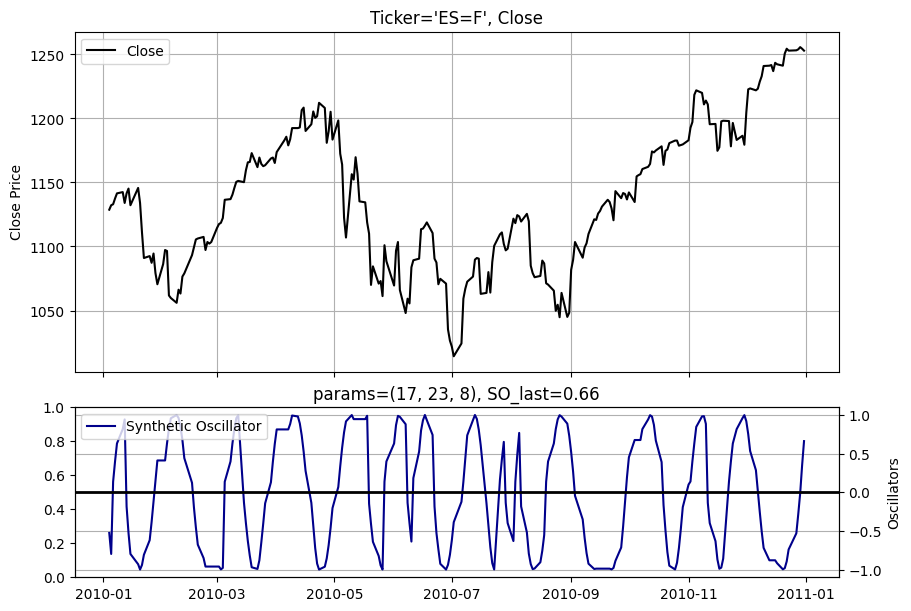

In [37]:
# Call trading strategy and plotting functions. 
# Use slicing technique to set plot start and end timeframes.
# Use argumemts on plotting function to enable or disable 
# various indicator plots

# example usage below shows closing price for instrument in top subplot
# and Synthetic Oscillator in the bottom subplot

# --- Set Indicator Parameters as desired ---
lower_bound = 17
upper_bound = 23
length = 8
params=(lower_bound, upper_bound, length)    
df = calc_trading_strategy(ohlcv, params)
plot_trading_signals(df['2010':'2010'], params, plot_so_ena=True, plot_roc2_ena=False, plot_buy_sell_ena=False)

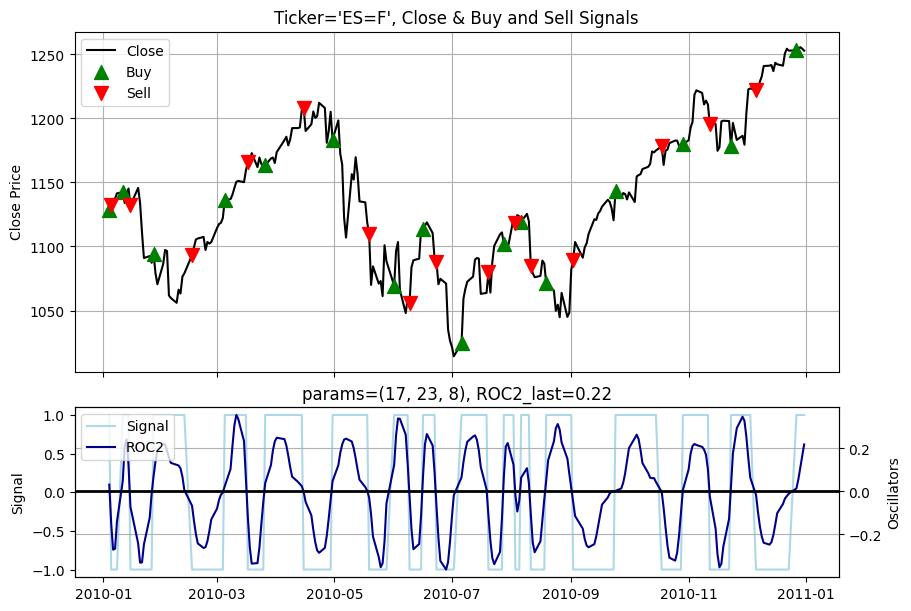

In [31]:
# Call trading strategy and plotting functions. 
# Use slicing technique to set plot start and end timeframes.
# Note the Signal line (light blue) generates the buy and sell
# signals as the ROC2 indicator goes above and below zero.
# Inspect plot for buy or sell signal.

# --- Set Indicator Parameters as desired ---
lower_bound = 17
upper_bound = 23
length = 8

params=(lower_bound, upper_bound, length)    
df = calc_trading_strategy(ohlcv, params)
plot_trading_signals(df['2010':'2010'], params, plot_so_ena=False, plot_roc2_ena=True, plot_buy_sell_ena=True)

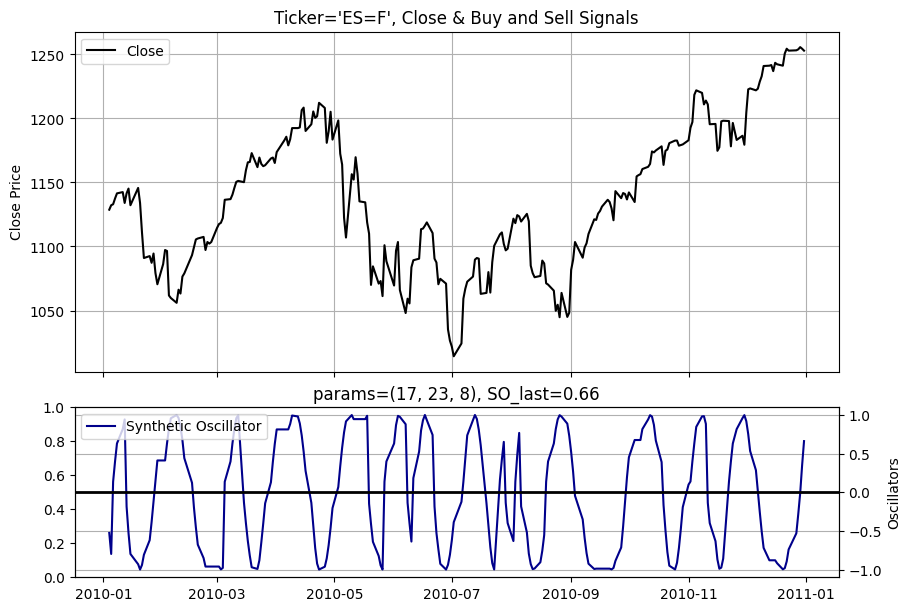

In [38]:
# Inspect resulting dataframe for a BUY or SELL Alert
# example below shows most recent last 12 days
df.tail(12)

Price,Open,High,Low,Close,Volume,SO,SO2,ROC2,Signal,Alert
Date,,,,,,,,,,
2026-01-29,7021.50,7029.50,6898.25,6992.75,1947645,0.843811,-0.243074,0.311695,1.0,
2026-01-30,6992.75,6995.00,6917.50,6965.75,2046596,0.973328,0.108183,0.351257,1.0,
2026-02-02,6938.50,7017.25,6864.50,7002.50,1491899,0.990477,0.430526,0.322343,1.0,
2026-02-03,7004.25,7027.25,6886.25,6941.75,1942807,0.873856,0.672271,0.241745,1.0,
2026-02-04,6934.00,6965.75,6862.50,6906.25,2145116,-0.181488,0.788890,0.116620,1.0,
2026-02-05,6915.50,6935.25,6785.00,6820.75,2107676,-0.510175,0.752397,-0.036494,-1.0,SELL
2026-02-06,6785.50,6965.50,6751.50,6952.75,1796075,-0.786417,0.561325,-0.191072,-1.0,
2026-02-09,6960.25,7000.50,6921.00,6983.25,1198044,-0.956450,0.243504,-0.317821,-1.0,
2026-02-10,6985.00,7006.50,6957.00,6961.50,1187062,0.183750,-0.101293,-0.344796,-1.0,


In [39]:
# Filter to inspect all BUY and SELL Alerts
# Use slicing techniques to zero in on specific time frames
cond = df['Alert'] != ''
df[cond]['2025':'2025'].head(10)

Price,Open,High,Low,Close,Volume,SO,SO2,ROC2,Signal,Alert
Date,,,,,,,,,,
2025-01-06,5994.50,6068.25,5980.75,6020.50,1547298,0.153293,0.464257,-0.083938,-1.0,SELL
2025-01-21,6032.25,6093.25,5994.50,6084.25,1725952,0.695379,-0.583799,0.155466,1.0,BUY
2025-01-29,6090.75,6111.50,6042.25,6067.50,1552941,-0.398401,0.776090,-0.031454,-1.0,SELL
2025-02-10,6016.00,6096.00,6014.00,6088.75,1005560,-0.188561,-0.811570,0.038364,1.0,BUY
2025-02-24,6040.75,6067.50,5994.50,6000.75,1797847,-0.398401,0.771863,-0.052688,-1.0,SELL
2025-03-06,5844.75,5853.50,5720.00,5746.25,2553819,-0.346211,-0.866938,0.013962,1.0,BUY
2025-03-27,5737.25,5779.75,5720.00,5739.25,1575855,0.516053,0.910790,-0.011942,-1.0,SELL
2025-04-10,5502.50,5528.75,5146.75,5302.00,2524214,0.136167,-0.869192,0.009284,1.0,BUY
2025-04-24,5409.00,5541.50,5355.25,5511.25,1411419,-0.092961,0.772892,-0.064819,-1.0,SELL


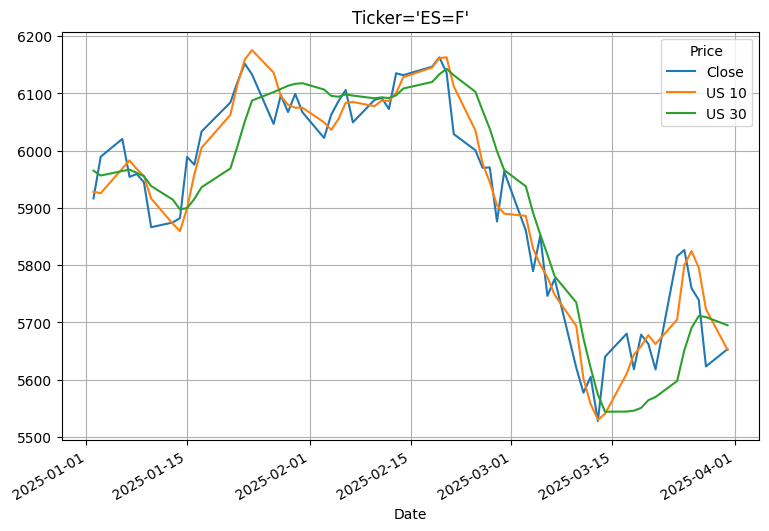

In [79]:
length = 10

df = ohlcv[['Close']].copy()
#df['SS'] = super_smoother(df['Close'], length)
#df['LP'] = hann_lowpass(df['Close'], length)
df['US 10'] = ultimate_smoother(df['Close'], period=10)
df['US 30'] = ultimate_smoother(df['Close'], period=30)
ax = df['2025':'2025-03'].plot(grid=True, figsize=(9,6), title=f"Ticker='{symbol}'")

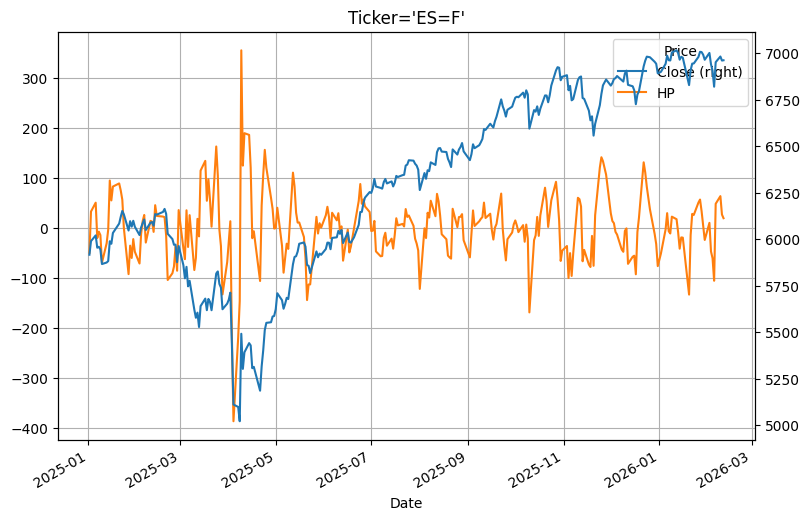

In [56]:
period = 21
df = ohlcv[['Close']].copy()
df['HP'] = high_pass(df['Close'], period)

cols = ['Close', 'HP']
ax = df['2025':][cols].plot(secondary_y='Close', grid=True, figsize=(9,6), title=f"Ticker='{symbol}'")

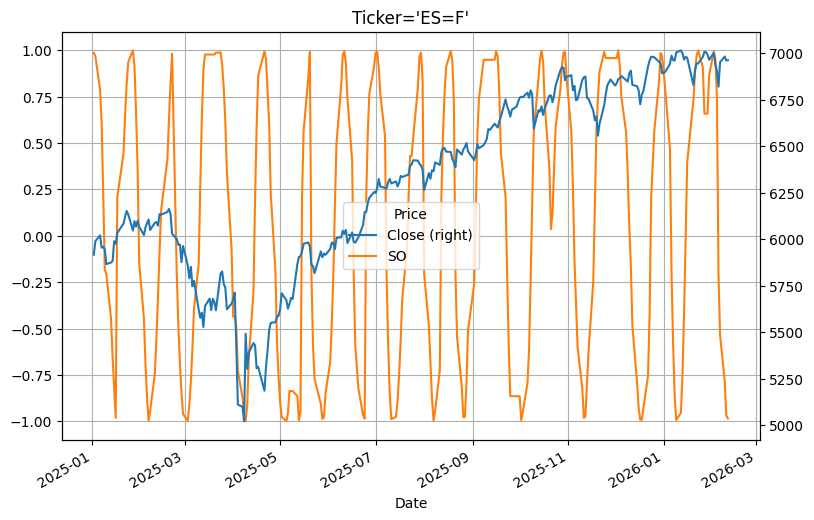

In [57]:
lower_bound = 15
upper_bound = 25
length = 4

df = ohlcv[['Close']].copy()
params=(lower_bound, upper_bound, length) 
df['SO'] = synthetic_oscillator(df['Close'], params)

cols = ['Close', 'SO']
ax = df['2025':].plot(secondary_y='Close',grid=True, figsize=(9,6), title=f"Ticker='{symbol}'")